In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from tqdm.notebook import trange
import pickle
from glv_functions import *
import random

In [3]:
mean = 0.13
std = 0.02


TEST_SEED  = 74
TRAIN_SEED = 73

In [3]:
def multi_species_model(p,t,  n , Gamma, sigma, mu):
    """
    Simulate a multispecies model of community growth. 
    
    Parameters
    ----------
    n: int
        The number of species to simulate
    
    Gamma: n x n np.array
        A matrix of the interaction terms where the ij-th term models the interaction
        strength of the ij-th species
    
    Sigma: n np.array
        A vector of the intrinsic external growth effect, generally set to a constant
    
    mu: n np.array
        A vector of the intrinsic growth rates of the bacteria
        
    p: n np.array
        A vector of the initial species distribution.
    """
    
    # We must construct a list of n elements, each corresponding to the growth derivative of each species
    dpdt = np.zeros(n)
    
    # Pull off all positive interactions and negative interactions
    Gamma_pos = Gamma*(Gamma > 0)
    Gamma_neg = Gamma*(Gamma < 0)
    
    # Compute the current value of the net positive and negative interaction terms
    gamma_pos = Gamma_pos @ p
    gamma_neg = Gamma_neg @ p
    

    dpdt = mu * p * ( np.ones(n) - p - sigma/(np.ones(n)+gamma_pos)  + gamma_neg )
    return dpdt

In [5]:
def random_parameters(n, int_mean, int_width, growth_mean, growth_var):
    # Generate simulation parameters
    time_range = np.linspace(0,2000,129)
    Gamma = int_width*np.random.randn(n,n) + int_mean*np.ones((n,n))
    sigma = 0.05*np.ones(n)
    mu = growth_mean*np.ones(n) + growth_var*np.random.randn(n)
    p_0 = 0.01*np.ones(n)
    # p_0 = np.random.random(n)*0.01

    return time_range, Gamma, sigma, mu, p_0

In [6]:
n = 7 # Small community size
int_mean = 100#1 # Mean interaction term \gamma_ij
int_width = 0.4 # Std of \gamma_ij
growth_var = 0.02 # variance of basal growth rate \mu_i
growth_mean = 1.0 / 250.0 # mean of basal growth rate \mu_j

(129, 7)


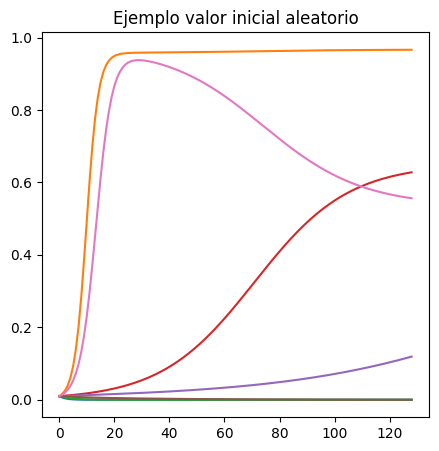

In [7]:
# Generate simulation paramters
params = random_parameters(n, mean, int_width, growth_mean, growth_var)
time_range, Gamma, sigma, mu, p_0  = params

# Integrate
sol = odeint(multi_species_model, p_0, time_range, args = (n,Gamma, sigma, mu, ))
print(sol.shape)
# Plote solution
plt.figure(figsize = (5,5))
plt.title("Ejemplo valor inicial aleatorio")
plt.plot(sol)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/carlosmarinoguera/Documents/IIT/OriginalPaper/data_generation/glv_functions.py:259: RuntimeWarning: invalid value encountered in subtract
  x = np.dot(np.diag(x), (r_k-x-np.dot(A, x)))


(5341, 129)


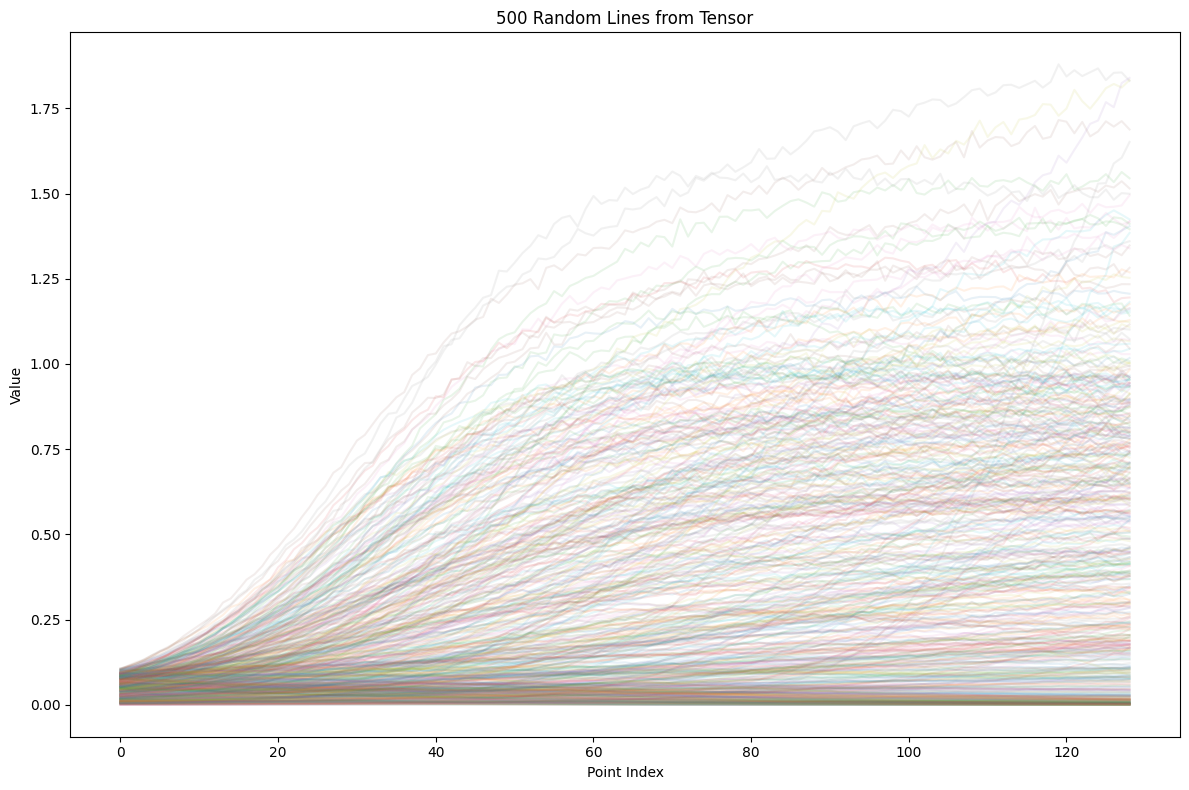

In [6]:
n = 7
SIGMA = 0.01
np.random.seed(TRAIN_SEED)
#np.random.seed(TEST_SEED)

sim_lists = []
for i in trange(1000):
    
    N_SIZE = 7  # dimension of the population
    RHO = np.random.rand() # correlation
    ALPHA = np.random.rand()*5 # interaction strength

    A = elliptic_normal_matrix(N_SIZE, RHO) / \
        (np.sqrt(N_SIZE)*ALPHA)  # Matrix of interactions


    # Parameter of the dynamics:
    NBR_IT = 129  # Number of iteractions
    TAU = 0.093  # Time step
    x_init = np.random.random(N_SIZE)*0.1  # Initial condition
    r = np.random.uniform(-0.2, 1, N_SIZE)
    #x_init = np.ones(N_SIZE) * 0.01


    # Compute the dynamics:
    sol = custom_dynamics_LV(A, x_init, nbr_it=NBR_IT, tau=TAU, r_k=r)  # y-axis


    # Roll new parameters
    #params = random_parameters(n, mean, int_width, growth_mean, growth_var)
    #time_range, Gamma, sigma, mu, p_0, = params

    # Integrate
    #old_sol = odeint(multi_species_model, p_0, time_range, args = (n,Gamma, sigma, mu,))
    # Add valid growth curves to the growing list. 

    shape = sol.shape
    noise = np.random.lognormal(mean=0, sigma=SIGMA, size=shape) # (7, 129)


    # Center the noise around 1
    scaling_factor = float(np.exp(SIGMA**2 / 2))


    centered_noise = noise / scaling_factor

    
    # Multiply the original tensor by the centered noise
    sol = sol * centered_noise

    if np.isnan(sol).any():
        pass
    elif sol[sol > 2.0].any():
        pass
    else:
        sim_lists.append(sol)

sols = np.array(sim_lists)
sols = sols.reshape(-1, 129)
print(sols.shape)
random_indices = np.random.choice(1000, 500, replace=False)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each selected line
for idx in random_indices:
    line = sols[idx]
    ax.plot(line, alpha=0.1)

# Customize the plot
ax.set_xlabel('Point Index')
ax.set_ylabel('Value')
ax.set_title('500 Random Lines from Tensor')


# Show the plot
plt.tight_layout()
plt.show()

(100, 129)


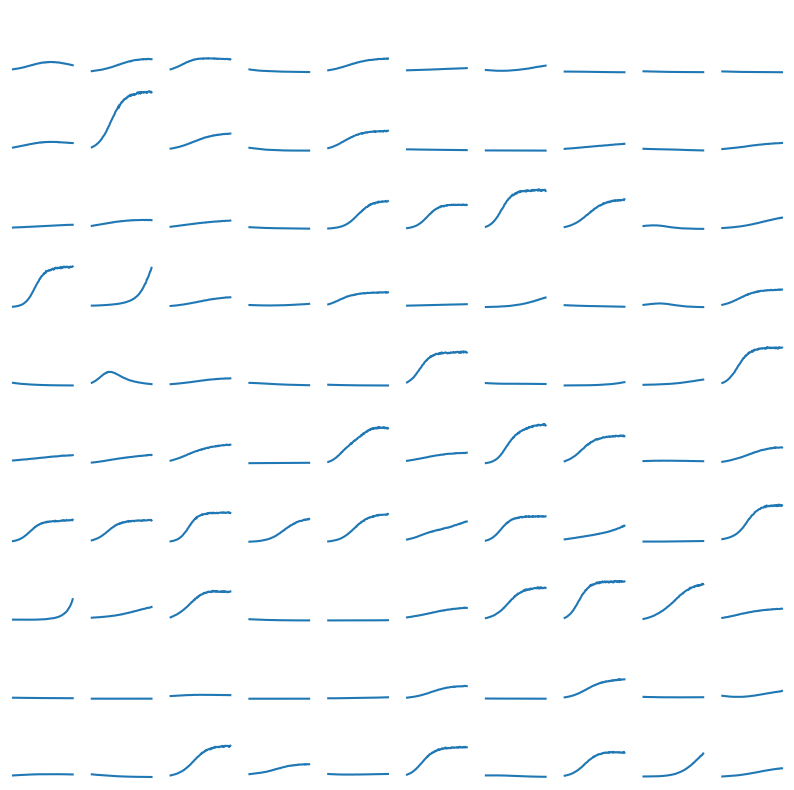

In [7]:
fig, axs = plt.subplots(10,10, figsize = (10,10), sharex = True, sharey = True)
axs = axs.flatten()

# Choose 100 curves at random and plot them

A = sols[np.random.randint(sols.shape[0],size = 100),:]

print(A.shape)
for i in range(100):
    axs[i].plot(A[i])
    axs[i].axis("off")
plt.show()

In [33]:
output = open('../data/test_paper_B.pkl', 'wb')
pickle.dump(sols, output)
output.close()

In [3]:
x = 8
x *= (1/8) 
x

1.0

In [9]:
file = open('../data/noisy_data.pkl','rb')

X = pickle.load(file)
file.close()
#X = np.loadtxt(data_route, delimiter = ",")
X = (X - X.min())/(X.max() - X.min())
X = X.reshape(( X.shape[0], 1, -1))

print(X.shape)

(30569, 1, 134)


(97860, 1, 129)
(1, 129)


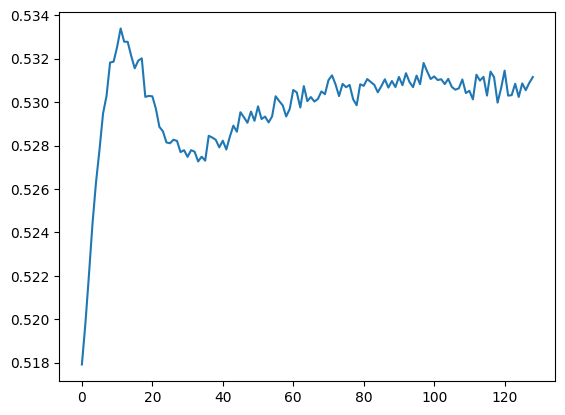

In [80]:
file = open('../data/paper_train_paper.pkl','rb')

X = pickle.load(file)
file.close()
#X = np.loadtxt(data_route, delimiter = ",")
X = (X - X.min())/(X.max() - X.min())
X = X.reshape(( X.shape[0], 1, -1))

print(X.shape)
line = X[random.randint(0,97000)]
print(line.shape)
plt.plot(line[0])